In [2]:
import tensorflow as tf
from pathlib import Path
import os 
import cv2 as cv
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Input
from datetime import datetime
import random
import numpy as np

In [3]:
print('GPU available? %s' % (len(tf.config.list_physical_devices(device_type='GPU')) > 0))
print('Build with CUDA? %s' % (tf.test.is_built_with_cuda()))

GPU available? True
Build with CUDA? True


### Constants

In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
DATAPATH = "data/"
EPOCH = 100
CHECKPOINT_PATH = '/checkpoints/'
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)
LOG_DIR = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
TRAIN_PCT = 0.8
seed = 123
random.seed = seed
np.random.seed = seed

## Defining U-Net basic model

#### Modèle 1
Reprendre pour pouvoir intéragir avec les différents hyperparamètres plus facilement

In [5]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(3, (1,1), padding="same", activation="softmax")(uconv1)
    
    return output_layer

input_layer = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
output_layer = build_model(input_layer, 16)
model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

#### Modèle 2

In [24]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)


c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)


c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)
 
model_2 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 256, 256, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 256, 256, 16) 0           conv2d_76[0][0]                  
____________________________________________________________________________________________

# Data processing & training

### Basic data processing

In [39]:
from tqdm import tqdm

def load_images():
    SourceImg = sorted(os.listdir(DATAPATH + 'images_cleaned/render'))
    TargetImg = sorted(os.listdir(DATAPATH + 'images_cleaned/ground'))
    for i in range(len(SourceImg)):
        # if count < 2165:
        #     count = count + 1
        img_1 = cv.imread(DATAPATH + 'images_cleaned/render/' + SourceImg[i])
        render = img_1.reshape(1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
        img_2 = cv.imread(DATAPATH + 'images_cleaned/ground/' + TargetImg[i])
        ground = img_2.reshape(1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
        yield(render, ground)

def create_dataset():
    render_path = str(DATAPATH)+'images/render/'
    mask_path = str(DATAPATH)+'images/ground/'
    images_ids = (sorted(os.listdir(render_path)), sorted(os.listdir(mask_path)))
    if len(images_ids[0]) != len(images_ids[1]):
        print('X and Y will have different number of data points! (X:%i and Y:%i)' % (len(images_ids[0]),len(images_ids[1])))
    X = np.zeros((len(images_ids[0]), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y = np.zeros((len(images_ids[1]), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    
    for n in tqdm(range(len(images_ids[0])), total = len(images_ids[0])):
        image_path = render_path + images_ids[0][n]
        img = cv.imread(image_path)[:,:,:IMG_CHANNELS]
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        X[n] = img
        image_mask_path = mask_path + images_ids[1][n]
        mask_ = cv.imread(image_mask_path)[:,:,:IMG_CHANNELS]
        mask_ = cv.cvtColor(mask_, cv.COLOR_BGR2RGB)
        mask_ = cv.resize(mask_, (256, 256))
        Y[n] = mask_
    return X, Y

def generate_dataset():
    render_path = str(DATAPATH)+'images/render/'
    mask_path = str(DATAPATH)+'images/ground/'
    images_ids = (sorted(os.listdir(render_path)), sorted(os.listdir(mask_path)))
    if len(images_ids[0]) != len(images_ids[1]):
        print('X and Y will have different number of data points! (X:%i and Y:%i)' % (len(images_ids[0]),len(images_ids[1])))
    
    for n in range(len(images_ids[0])):
        image_path = render_path + images_ids[0][n]
        img = cv.imread(image_path)[:,:,:IMG_CHANNELS]
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        image_mask_path = mask_path + images_ids[1][n]
        mask_ = cv.imread(image_mask_path)[:,:,:IMG_CHANNELS]
        mask_ = cv.cvtColor(mask_, cv.COLOR_BGR2RGB)
        mask_ = cv.resize(mask_, (256, 256))
        X_input = img.reshape(1,256,256,3)
        Y_input = img.reshape(1,256,256,3)
        yield (X_input, Y_input)


In [ ]:
X,Y= create_dataset()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        prediction_test()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, 
                                     save_weights_only=True,
                                     verbose=1),
  tf.keras.callbacks.CSVLogger('logs.csv', separator=',', append=False)
]
def train_model(model):
    """Train transfer learning model with given hyperparameters and test against a given image."""
    # parsing()
    model.fit(X, Y, validation_split=0.2, epochs = 5, batch_size= 16, verbose = 1)
    
def train_model_w_generator(model):
    """Train transfer learning model with given hyperparameters and test against a given image."""
    # parsing()
    model.fit(generate_dataset(), epochs = 50, verbose = 1, steps_per_epoch=100, shuffle=True)
    
train_model(model_2)

In [50]:
!conda install matplotlib --yes --all

Solving environment: done

## Package Plan ##

  environment location: /home/querashi/miniconda3/envs/tensorflow-gpu

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.10.0              |           py37_0          13 KB
    dbus-1.13.12               |       h746ee38_0         501 KB
    gst-plugins-base-1.14.0    |       hbbd80ab_1         4.8 MB
    gstreamer-1.14.0           |       hb453b48_1         3.1 MB
    kiwisolver-1.1.0           |   py37he6710b0_0          82 KB
    matplotlib-3.1.3           |           py37_0          21 KB
    matplotlib-base-3.1.3      |   py37hef1b27d_0         5.0 MB
    pyqt-5.9.2                 |   py37h05f1152_2         4.5 MB
    qt-5.9.7                   |       h5867ecd_1        68.5 MB
    sip-4.19.8                 |   py37hf484d3e_0         274 KB
    ----------------------------------------

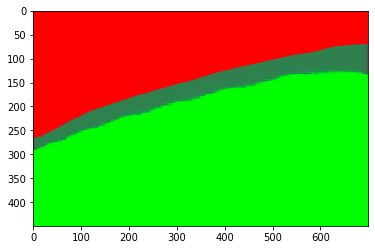

In [62]:
import matplotlib.pyplot as plt
img_x = cv.imread(DATAPATH + "images/render/render0010.png")
img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(256,256))
img_x = img_x.reshape(1,256,256,3)
prediction = model_2.predict(img_x)
pred = prediction.reshape(256,256,3)
pred_ = cv.resize(pred,(700,450))

plt.imshow(pred_)

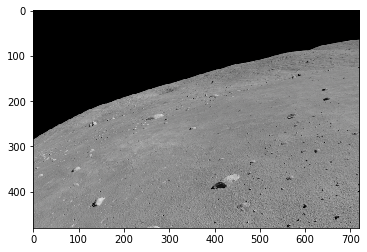

In [63]:
plt.imshow(cv.imread(DATAPATH + "images/render/render0010.png"))

In [107]:
def parsing():
    """
    Loads the content of artificial-lunar-rocky-landscape-dataset, the
    location of this directory is set in config.py
    It modifies the images and writes them in artificial-lunar-rocky-landscape-dataset/images_cleaned

     """

    Path(DATAPATH + "images_cleaned/render/").mkdir(parents=True, exist_ok=True)
    Path(DATAPATH + "images_cleaned/ground/").mkdir(parents=True, exist_ok=True)

    '''Here we will not run this function if it has already run'''
    print(os.getcwd())
    len_render = len(os.listdir(DATAPATH + "images_cleaned/render/"))
    len_ground = len(os.listdir(DATAPATH + "images_cleaned/ground/"))
    if len_render > 200 & (len_render == len_ground):
        answer = input('Do you want to recreate the reshaped images directory? Answer with YES or NO and press enter \n')
        if answer != "YES":
            return

    SourceImg = sorted(os.listdir(DATAPATH + 'images/render'))
    TargetImg = sorted(os.listdir(DATAPATH + 'images/ground'))

    for i in range(len(SourceImg)):
        # if count < 2165:
        #     count = count + 1
            img_1 = cv.imread(DATAPATH + 'images/render/' + SourceImg[i])
            img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
            img_1 = cv.resize(img_1, (256, 256))
            cv.imwrite(f"{DATAPATH}images_cleaned/render/img_{i}.png", img_1)
            img_2 = cv.imread(DATAPATH + 'images/ground/' + TargetImg[i])
            img_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)
            img_2 = cv.resize(img_2, (256, 256))
            cv.imwrite(f"{DATAPATH}/images_cleaned/ground/img_{i}.png", img_2)


def load_images():
    SourceImg = sorted(os.listdir(DATAPATH + 'images_cleaned/render'))
    TargetImg = sorted(os.listdir(DATAPATH + 'images_cleaned/ground'))
    for i in range(len(SourceImg)):
        # if count < 2165:
        #     count = count + 1
        img_1 = cv.imread(DATAPATH + 'images_cleaned/render/' + SourceImg[i])
        render = img_1.reshape(1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
        img_2 = cv.imread(DATAPATH + 'images_cleaned/ground/' + TargetImg[i])
        ground = img_2.reshape(1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
        yield(render, ground)
        


In [88]:
def prediction_test(im_number=1):
    if im_number < 0:
        return
    SourceImg = sorted(os.listdir(DATAPATH + 'images/render'))
    img_x = cv.imread(DATAPATH + "images/render/" + SourceImg[int(im_number) - 1])
    img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
    img_x = cv.resize(img_x, (500, 500))
    img_x = img_x.reshape(1, 500, 500, 3)
    prediction = model.predict(img_x)
    pred = prediction.reshape(500, 500, 3)
    pred_ = cv.resize(pred, (700, 450))
    plt.imshow(pred_)
    plt.show()

In [110]:
train_model(model)

/home/querashi/Documents/Lunar_Landscape_Detection
Do you want to recreate the reshaped images directory? Answer with YES or NO and press enter 
YES
  ...
    to  
  ['...']
Epoch 1/100
9766/9766 [==============================] - 195s 20ms/step - loss: nan - accuracy: 0.8771
Epoch 2/100
   0/9766 [..............................] - ETA: 0s

ValueError: Empty training data.